# Tiny NeRF

In [1]:
import os, sys
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load data and visualize

In [2]:
data = np.load('tiny_nerf_data.npz')
images = data['images'] # (N_views, H, W, 3)
poses = data['poses'] # (N_views, 4, 4)
focal = data['focal'] # () in pixels
print(images.shape, poses.shape, focal)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


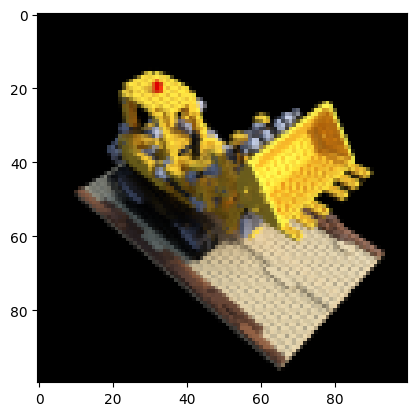

In [3]:
height, width = images.shape[1:3]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
      device = torch.device('mps')

images = torch.from_numpy(images).to(device, dtype=torch.float32)
poses = torch.from_numpy(poses).to(device, dtype=torch.float32)
focal = torch.tensor(focal).to(device, dtype=torch.float32)

test_img, test_pose = images[101], poses[101]
images = images[:100]
poses = poses[:100]

plt.imshow(test_img.cpu().numpy())
plt.show()

## Positional Encoding

In [4]:
L_embed = 6

def posenc(x):
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.cat(rets, -1)

In [5]:
# testing posenc
x = torch.linspace(-1., 1., 10)
print(x)
posenc(x).shape

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])


torch.Size([130])

## Create model

In [6]:
class NeRF(torch.nn.Module):
    def __init__(self, D=8, W=256):
        super().__init__()
        self.D = D
        self.W = W
        self.pts_linears = torch.nn.ModuleList([torch.nn.Linear(L_embed, W)] + [torch.nn.Linear(W, W) for _ in range(D-1)])
        self.views_linears = torch.nn.ModuleList([torch.nn.Linear(L_embed, W)] + [torch.nn.Linear(W, W) for _ in range(D-1)])
        self.pts_out = torch.nn.Linear(W, 4)
        self.views_out = torch.nn.Linear(W, 256+3)
    

    def forward(self, pts, views):
        pts = posenc(pts)
        views = posenc(views)
        for i in range(self.D):
            pts = self.pts_linears[i](pts)
            views = self.views_linears[i](views)
            pts = torch.nn.functional.relu(pts)
            views = torch.nn.functional.relu(views)
        rgb = torch.sigmoid(self.pts_out(pts))
        sigma = torch.nn.functional.relu(self.views_out(views))
        return torch.cat([rgb, sigma], -1)

In [7]:
def get_rays(height, width, focal, c2w):
    i, j = torch.meshgrid(torch.linspace(0., width-1., width), torch.linspace(0., height-1., height))
    i = i.t().to(device)
    j = j.t().to(device)
    dirs = torch.stack([(i-width*.5)/focal, -(j-height*.5)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.shape)
    return rays_o, rays_d

## Visualize Rays

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_rays(rays_o, rays_d, title):
    rays_o = rays_o.cpu().numpy()[0:2]
    rays_d = rays_d.cpu().numpy()[0:2]

    fig = make_subplots(
        rows=1,
        cols=3,
        specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
        subplot_titles=["X", "Y", "Z"],
    )
    for i in range(3):
        fig.add_trace(
            go.Scatter3d(
                x=rays_o[:, i, 0],
                y=rays_o[:, i, 1],
                z=rays_o[:, i, 2],
                mode="markers",
                marker=dict(size=1),
            ),
            row=1,
            col=i + 1,
        )
        fig.add_trace(
            go.Cone(
                x=rays_o[:, i, 0],
                y=rays_o[:, i, 1],
                z=rays_o[:, i, 2],
                u=rays_d[:, i, 0],
                v=rays_d[:, i, 1],
                w=rays_d[:, i, 2],
                sizemode="absolute",
                sizeref=1,
                showscale=False,
            ),
            row=1,
            col=i + 1,
        )
    fig.update_layout(title=title, margin=dict(l=0, r=0, b=0, t=0))
    fig.show()


# plot the test rays
rays_o, rays_d = get_rays(height, width, focal, test_pose.inverse())
plot_rays(rays_o, rays_d, "Test Rays")